In [36]:
from reddit.utils import load_tfrecord
from reddit import BatchTransformer
from transformers import TFDistilBertModel
import umap
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import glob
import pandas as pd
import gzip
import os
from reddit.utils import triplet_transform
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import json

Read in the data

In [2]:
fs = sorted(glob.glob('../reddit/data/datasets/triplet/1pos_1neg_random/test/*'))[:1]
fs_js = sorted(glob.glob('../reddit/data/json/triplet/1pos_1neg_random/test/*'))[:1]
data = load_tfrecord(fs, ds_type='triplet').take(1000)

In [3]:
els = []
for fj in fs_js:
    els += json.load(gzip.open(fj))

In [4]:
author_ids = [i['author_id'].numpy() for i in data]

In [5]:
els_sorted = []
for a in author_ids:
    els_sorted.append([e for e in els if e['author_id']==a][0])

Get the model in place

In [6]:
base = '../logs/triplet/1anchor/standard/checkpoint/'
base2 = '../logs/triplet/first_models/10anchor_1pos_1neg_random/'
m1 = 'BatchTransformer-6layers-nodense-noint-cls-distilbert_base_uncased/'
m2 = 'BatchTransformer-distilbert-base-uncased/'
loss = 'triplet_loss_margin-1.0/epoch-0/'
model1 = base + m1 + loss
model2 = base2 + 'checkpoint/' + m2 +  loss

In [7]:
cp = tf.train.latest_checkpoint(model1)
cp2 = tf.train.latest_checkpoint(model2)

In [35]:
def _make_model(weights):
    basic = BatchTransformer(transformer=TFDistilBertModel,
                             pretrained_weights='distilbert-base-uncased')
    if weights is not None:
        basic.load_weights(weights)
    return weights

Preprocess the dataset and encode

In [18]:
data_prepped1 = triplet_transform(data, 
                                  pad_to=[10,1,1],
                                  batch_size=4, 
                                  n_anchor=1)
data_prepped10 = triplet_transform(data, 
                                   pad_to=[10,1,1],
                                   batch_size=4, 
                                   n_anchor=10)

In [ ]:
model = _make_dataset(weights=cp) # cp2, None

In [ ]:
res1 = []
for d in data_prepped1.take(40): 
    res1.append(t1(d)[:,0,:])
arr = tf.concat(res1, axis=0).numpy()
df = pd.DataFrame(arr)
df['text'] = [e['anchor'][0] for e in els_sorted[:160]]
#df.to_csv('data/model_10anchor_single.csv', index=False)

In [ ]:
# Potentially implement with others

PCA and plot in plotly

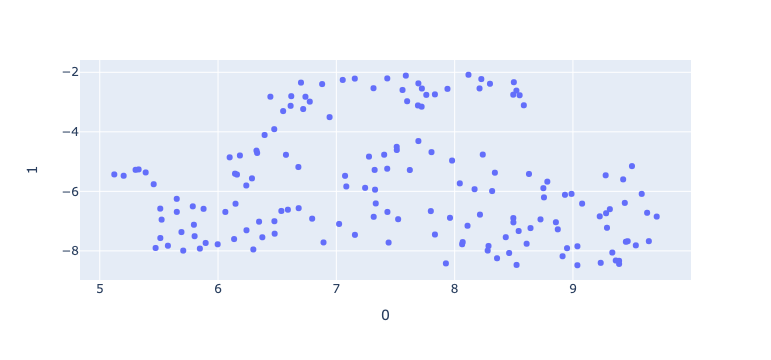

In [63]:
from umap import UMAP
import numpy as np
import plotly.express as px
features = df.iloc[:, :768]
umap = UMAP(n_components=2, init='random', random_state=0)
proj = pd.DataFrame(umap.fit_transform(features))
proj['text'] = [' '.join([' '.join(i.split()[x:x+10])+'<br>' 
                          for x in np.arange(0,len(i[:500].split()),10)]) 
                for i in df['text'].tolist()]
fig = px.scatter(proj, x=0, y=1,
                hover_data=['text'])
fig.show()

In [ ]:
# Pick some sentences and look at most similar in the dataset across spaces